# Electricity Market Fundamentals

This lesson introduces electricity market concepts through optimization models. You will implement basic market clearing mechanisms, understand price formation, and explore the relationship between physical constraints and market outcomes. The focus is on building intuition for how markets translate engineering constraints into economic signals.

## Learning Objectives

By the end of this lesson, you will be able to:
- Understand the transition from regulated utilities to competitive electricity markets
- Implement single-period market clearing algorithms
- Analyze how transmission constraints create Locational Marginal Price (LMP) separation
- Model multi-settlement market systems
- Incorporate ancillary service requirements into market models
- Evaluate market power impacts on pricing

## Prerequisites

Before starting this lesson, you should have completed:
- Module 03, Lesson 1: Optimization Fundamentals
- Module 03, Lesson 2: Linear Programming with Python


In [24]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import pulp
import pandas as pd
from pulp import *

## From Regulated to Market Systems

### Historical Context

Electricity systems have evolved from vertically integrated utilities to competitive markets:

**Vertically Integrated Utilities (Pre-1990s):**
- Single company owned generation, transmission, and distribution
- Centralized optimization of the entire system
- Regulated rates based on cost-of-service
- Economic dispatch performed by utility control centers

**Market Restructuring (1990s-Present):**
- Separation of generation, transmission, and distribution
- Competitive generation markets
- Independent System Operators (ISOs) manage grid operations
- Prices determined through market mechanisms

### Why Markets?

Markets provide several advantages:
- **Economic efficiency**: Competitive forces drive down costs
- **Innovation incentives**: Rewards for new technologies and efficiency improvements
- **Price signals**: Market prices guide investment and operational decisions
- **Consumer choice**: Ability to choose electricity suppliers

### The Role of Optimization

Even in competitive markets, optimization remains central:
- **Market clearing**: ISOs solve optimization problems to determine prices and dispatch
- **System reliability**: Physical constraints must be respected
- **Social welfare maximization**: Markets designed to maximize total economic benefit

The key difference is that optimization now serves to clear markets rather than minimize costs for a single utility.

## Single Period Market Clearing

### Basic Market Model

In a single-period energy market:
- **Generators** submit supply offers (price-quantity pairs)
- **Load** represents demand (initially assumed price-inelastic)
- **ISO** clears the market by solving an optimization problem
- **Locational Marginal Price (LMP)** is determined from the optimization dual variables

### Market Clearing Formulation

The market clearing problem maximizes social welfare:

**Objective:** Maximize (Consumer Surplus - Producer Cost)

For price-inelastic demand, this becomes:
**Minimize:** Total Generation Cost

**Subject to:**
- Power balance: Generation = Demand
- Generator limits: P_min ≤ P_gen ≤ P_max
- Transmission constraints (if applicable)

Let's implement a simple single-bus market clearing:

In [25]:
def single_bus_market_clearing(generators, demand):
    """
    Clear a single-bus electricity market
    
    Parameters:
    generators: dict with 'names', 'mc' (marginal cost), 'p_min', 'p_max'
    demand: float, total system demand (MW)
    
    Returns:
    dict with dispatch results and market price
    """
    
    # Create optimization problem
    prob = LpProblem("Single_Bus_Market", LpMinimize)
    
    # Decision variables: generation from each unit
    p_gen = {}
    for name in generators['names']:
        idx = generators['names'].index(name)
        p_gen[name] = LpVariable(f"P_{name}", 
                                generators['p_min'][idx], 
                                generators['p_max'][idx])
    
    # Objective: minimize total generation cost
    prob += lpSum(generators['mc'][generators['names'].index(name)] * p_gen[name] 
                  for name in generators['names'])
    
    # Constraint: supply must meet demand
    prob += lpSum(p_gen[name] for name in generators['names']) == demand, "Power_Balance"
    
    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
        'status': LpStatus[prob.status],
        'dispatch': {name: value(p_gen[name]) for name in generators['names']},
        'total_cost': value(prob.objective),
        'lmp': prob.constraints['Power_Balance'].pi  # LMP from dual variable
    }
    
    return results

# Example market data
generators = {
    'names': ['Coal', 'Gas_CC', 'Gas_CT'],
    'mc': [25, 35, 55],      # Marginal cost ($/MWh)
    'p_min': [50, 100, 0],   # Minimum generation (MW)
    'p_max': [200, 300, 150] # Maximum generation (MW)
}

demand = 400  # MW

# Clear the market
results = single_bus_market_clearing(generators, demand)

print(f"Market Status: {results['status']}")
print(f"\nGeneration Dispatch:")
for name, dispatch in results['dispatch'].items():
    idx = generators['names'].index(name)
    cost = generators['mc'][idx]
    print(f"{name:8}: {dispatch:6.1f} MW at ${cost}/MWh")

print(f"\nTotal Generation Cost: ${results['total_cost']:,.2f}")
print(f"Locational Marginal Price: ${results['lmp']:.2f}/MWh")

Market Status: Optimal

Generation Dispatch:
Coal    :  200.0 MW at $25/MWh
Gas_CC  :  200.0 MW at $35/MWh
Gas_CT  :    0.0 MW at $55/MWh

Total Generation Cost: $12,000.00
Locational Marginal Price: $35.00/MWh


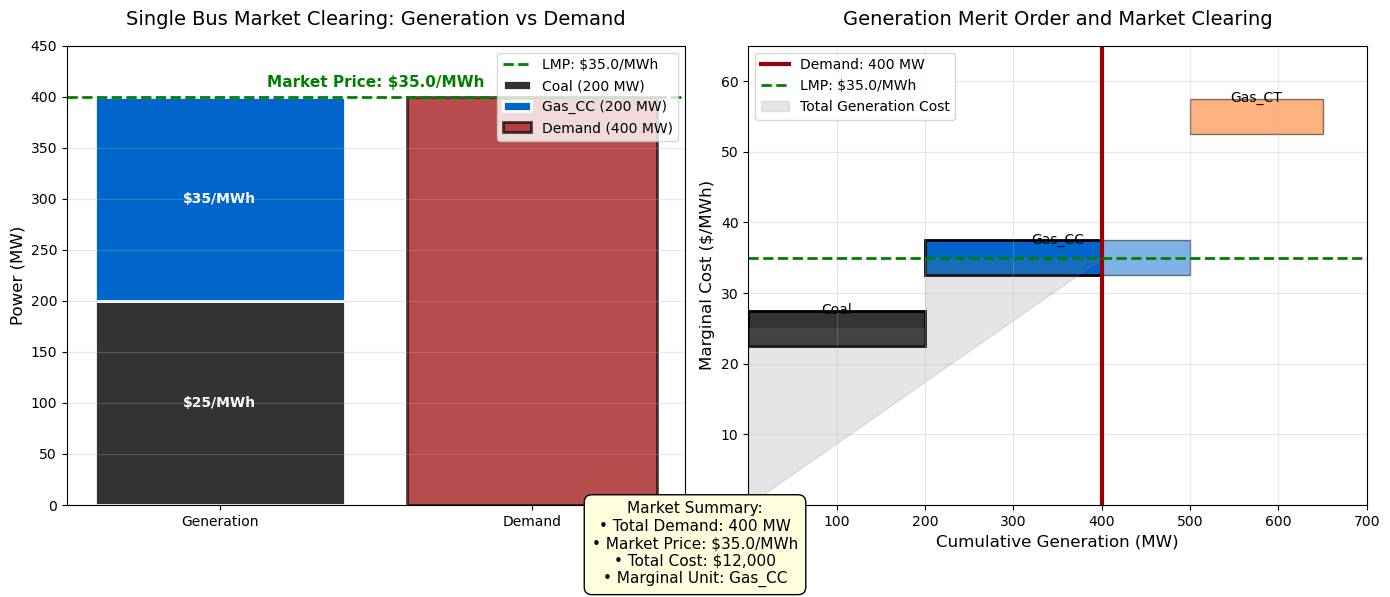

In [26]:
"""
Visualization for Single Bus Market Clearing Example
Creates a bar chart showing generation dispatch and demand
"""

import matplotlib.pyplot as plt
import numpy as np

# Market data from the notebook example
generators = {
    'names': ['Coal', 'Gas_CC', 'Gas_CT'],
    'mc': [25, 35, 55],      # Marginal cost ($/MWh)
    'p_min': [50, 100, 0],   # Minimum generation (MW)
    'p_max': [200, 300, 150] # Maximum generation (MW)
}

# Results from the market clearing (demand = 400 MW)
dispatch_results = {
    'Coal': 200.0,
    'Gas_CC': 200.0,
    'Gas_CT': 0.0
}

demand = 400  # MW
lmp = 35.00   # $/MWh

# Create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Generation stack and demand
ax1.set_title('Single Bus Market Clearing: Generation vs Demand', fontsize=14, pad=15)

# Create stacked bar for generation
colors = ['#333333', '#0066CC', '#FF6600']  # Coal=black, Gas_CC=blue, Gas_CT=orange
bottom = 0
gen_bars = []

for i, name in enumerate(generators['names']):
    height = dispatch_results[name]
    if height > 0:
        bar = ax1.bar('Generation', height, bottom=bottom, 
                      color=colors[i], label=f'{name} ({height:.0f} MW)', 
                      edgecolor='white', linewidth=2)
        gen_bars.append(bar)
        
        # Add marginal cost label in the middle of each segment
        if height > 20:  # Only add label if segment is large enough
            ax1.text(0, bottom + height/2, f'${generators["mc"][i]}/MWh', 
                    ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        bottom += height

# Add demand bar
demand_bar = ax1.bar('Demand', demand, color='#990000', alpha=0.7, 
                     label=f'Demand ({demand} MW)', edgecolor='black', linewidth=2)

# Add LMP line
ax1.axhline(y=400, color='green', linestyle='--', linewidth=2, label=f'LMP: ${lmp}/MWh')
ax1.text(0.5, 410, f'Market Price: ${lmp}/MWh', ha='center', fontsize=11, fontweight='bold', color='green')

ax1.set_ylabel('Power (MW)', fontsize=12)
ax1.set_ylim(0, 450)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Right plot: Merit order curve
ax2.set_title('Generation Merit Order and Market Clearing', fontsize=14, pad=15)

# Create merit order data
merit_order = []
for i, name in enumerate(generators['names']):
    merit_order.append({
        'name': name,
        'mc': generators['mc'][i],
        'capacity': generators['p_max'][i],
        'dispatched': dispatch_results[name]
    })

# Sort by marginal cost
merit_order.sort(key=lambda x: x['mc'])

# Plot merit order curve
cumulative_capacity = 0
for i, gen in enumerate(merit_order):
    # Plot available capacity
    ax2.barh(gen['mc'], gen['capacity'], left=cumulative_capacity, 
             height=5, color=colors[generators['names'].index(gen['name'])], 
             alpha=0.5, edgecolor='black', linewidth=1)
    
    # Plot dispatched amount
    if gen['dispatched'] > 0:
        ax2.barh(gen['mc'], gen['dispatched'], left=cumulative_capacity, 
                 height=5, color=colors[generators['names'].index(gen['name'])], 
                 edgecolor='black', linewidth=2)
    
    # Add generator label
    ax2.text(cumulative_capacity + gen['capacity']/2, gen['mc'] + 2, 
             gen['name'], ha='center', fontsize=10)
    
    cumulative_capacity += gen['capacity']

# Add demand line
ax2.axvline(x=demand, color='#990000', linestyle='-', linewidth=3, label=f'Demand: {demand} MW')

# Add LMP line
ax2.axhline(y=lmp, color='green', linestyle='--', linewidth=2, label=f'LMP: ${lmp}/MWh')

# Shade area under merit order curve up to demand
x_points = [0]
y_points = [0]
cumulative = 0

for gen in merit_order:
    if cumulative < demand:
        x_points.append(cumulative)
        y_points.append(gen['mc'])
        
        next_cumulative = min(cumulative + gen['dispatched'], demand)
        x_points.append(next_cumulative)
        y_points.append(gen['mc'])
        
        cumulative = next_cumulative
        
        if cumulative >= demand:
            break

ax2.fill(x_points, y_points, alpha=0.2, color='gray', label='Total Generation Cost')

ax2.set_xlabel('Cumulative Generation (MW)', fontsize=12)
ax2.set_ylabel('Marginal Cost ($/MWh)', fontsize=12)
ax2.set_xlim(0, sum(gen['capacity'] for gen in merit_order) + 50)
ax2.set_ylim(0, 65)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add summary text box
summary_text = (
    f"Market Summary:\n"
    f"• Total Demand: {demand} MW\n"
    f"• Market Price: ${lmp}/MWh\n"
    f"• Total Cost: ${dispatch_results['Coal'] * 25 + dispatch_results['Gas_CC'] * 35:,.0f}\n"
    f"• Marginal Unit: Gas_CC"
)

# Place text box in figure
fig.text(0.5, 0.02, summary_text, ha='center', fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='black'))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()

### Exercise 1: Market Clearing Verification

**Task:** Verify that the LMP equals the marginal cost of the marginal unit (the most expensive unit that is dispatched) in this example.

1. Run the market clearing with **demand = 301 MW**
2. Identify which generators are dispatched and which is marginal
3. Compare the LMP to the marginal cost of the marginal unit
4. Explain why they should be equal in an optimal solution

In [27]:
# Exercise 1 Solution

# Test with different demand level
demand_test = 301  # MW
results_test = single_bus_market_clearing(generators, demand_test)

print(f"Demand: {demand_test} MW")
print(f"Generation Dispatch:")
dispatched_units = []
for name, dispatch in results_test['dispatch'].items():
    idx = generators['names'].index(name)
    cost = generators['mc'][idx]
    print(f"{name:8}: {dispatch:6.1f} MW at ${cost}/MWh")
    if dispatch > 0.01:  # Consider dispatched if > 0.01 MW
        dispatched_units.append((name, cost, dispatch))

print(f"\nLocational Marginal Price: ${results_test['lmp']:.2f}/MWh")


# Find marginal unit (highest cost dispatched unit)
marginal_unit = max(dispatched_units, key=lambda x: x[1])
print(f"\nMarginal Unit: {marginal_unit[0]} with cost ${marginal_unit[1]}/MWh")
print(f"LMP matches marginal cost: {abs(results_test['lmp'] - marginal_unit[1]) < 0.01}")

Demand: 301 MW
Generation Dispatch:
Coal    :  200.0 MW at $25/MWh
Gas_CC  :  101.0 MW at $35/MWh
Gas_CT  :    0.0 MW at $55/MWh

Locational Marginal Price: $35.00/MWh

Marginal Unit: Gas_CC with cost $35/MWh
LMP matches marginal cost: True


:::{admonition} Numerical Issue
:class: dropdown

When running Exercise 1 with demand = 300 MW (instead of 301 MW), the solver reports
LMP = \$25/MWh, which may seem incorrect.
Since Coal is at its maximum capacity (200 MW) and cannot produce more, any additional demand must be met
by Gas_CC at \$35/MWh, making Gas_CC the marginal unit. The LMP should therefore be \$35/MWh.

This is a numerical edge case that occurs when generators are exactly at their capacity limits. Testing
with demand = 301 MW correctly shows LMP = \$35/MWh. This highlights the importance of understanding the
economic interpretation: the LMP represents the cost to serve the next MW of load, which comes from the
marginal generator that can actually increase its output.

:::

## Network Constraints and LMP Separation

### Adding Transmission to Markets

Real electricity markets must account for transmission constraints. When transmission lines reach their limits, the market cannot freely move power from low-cost to high-cost areas, creating **LMP separation**.

### DC Power Flow Model

For market clearing, we typically use the **DC power flow** approximation:
- Power flows are linear functions of voltage angle differences
- **PTDF (Power Transfer Distribution Factor)** matrix relates net injections to line flows
- Line flow = PTDF × Net Injection

### Market Clearing with Transmission

The optimization problem becomes:

**Minimize:** Total Generation Cost

**Subject to:**
- Power balance at each bus
- Generator limits
- **Transmission line flow limits**

Let's implement a 3-bus market with transmission constraints:

In [5]:
# Input data for the three-bus system
gen_data = {
    'names': ['Gen1', 'Gen2', 'Gen3'],
    'bus': [0, 1, 2],
    'mc': [20, 35, 15],              # Marginal costs ($/MWh)
    'p_min': [0, 0, 0],              # Minimum generation (MW)
    'p_max': [100, 100, 150]          # Maximum generation (MW)
}

demand_data = {0: 20, 1: 110, 2: 30}  # Demand at each bus (MW)

# Network data with PTDF matrix
network_data = {
  'ptdf': [
      [0.6, -0.3, -0.3],    # Line 0-1
      [-0.2, 0.4, -0.2],    # Line 1-2
      [-0.4, -0.1, 0.5]     # Line 0-2
  ],
  'flow_limits': [50, 40, 60]
}

line_names = ['0-1', '1-2', '0-2']

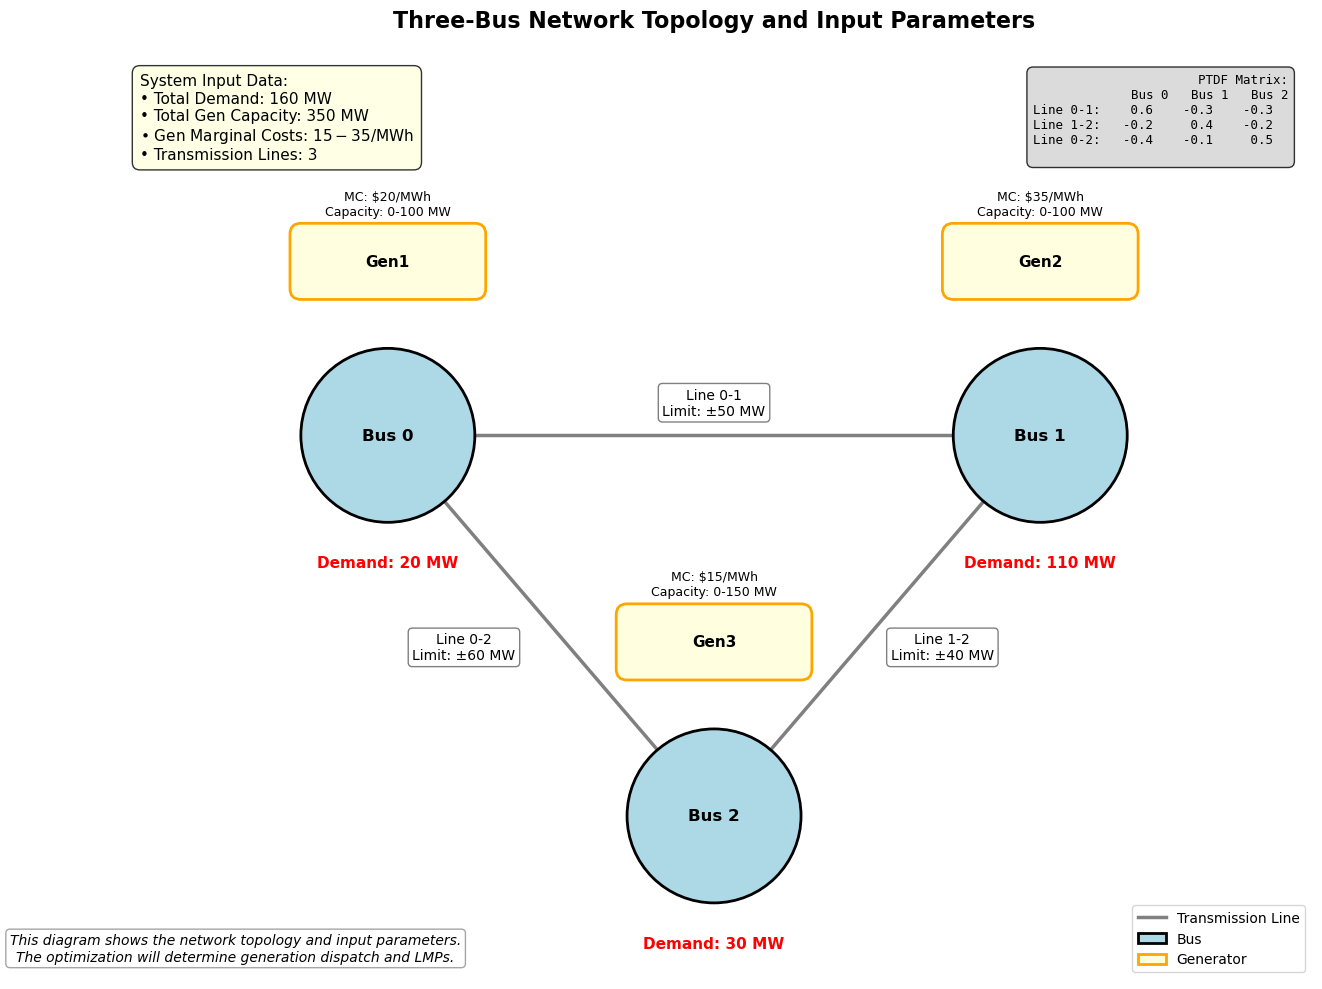

In [6]:
"""
Visualization for Three-Bus Network Topology and Input Data
Shows the network structure and given parameters before optimization
"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Bus positions (triangle layout)
bus_positions = {
    0: (0.2, 0.5),    # Left
    1: (0.8, 0.5),    # Right
    2: (0.5, 0.15)    # Bottom center
}

# Draw transmission lines first (so they appear behind buses)
line_connections = [(0, 1), (1, 2), (0, 2)]
for i, (from_bus, to_bus) in enumerate(line_connections):
    x1, y1 = bus_positions[from_bus]
    x2, y2 = bus_positions[to_bus]
    
    # Draw line
    ax.plot([x1, x2], [y1, y2], color='gray', linewidth=2.5, zorder=1)
    
    # Add flow limit label at midpoint
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Offset label to avoid overlapping with line
    if from_bus == 0 and to_bus == 2:  # Line 0-2
        offset_x, offset_y = -0.08, -0.02
    elif from_bus == 1 and to_bus == 2:  # Line 1-2
        offset_x, offset_y = 0.06, -0.02
    else:  # Line 0-1
        offset_x, offset_y = 0, 0.03
    
    limit_text = f"Line {line_names[i]}\nLimit: ±{network_data['flow_limits'][i]} MW"
    ax.text(mid_x + offset_x, mid_y + offset_y, limit_text, 
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))

# Draw buses
bus_radius = 0.08
for bus_id, (x, y) in bus_positions.items():
    # Draw bus circle
    circle = plt.Circle((x, y), bus_radius, facecolor='lightblue', 
                       edgecolor='black', linewidth=2, zorder=2)
    ax.add_patch(circle)
    
    # Add bus number
    ax.text(x, y, f"Bus {bus_id}", ha='center', va='center', 
            fontsize=12, fontweight='bold')
    
    # Add demand info below bus
    demand_text = f"Demand: {demand_data[bus_id]} MW"
    ax.text(x, y - bus_radius - 0.03, demand_text, ha='center', va='top', 
            fontsize=11, color='red', fontweight='bold')

# Draw generators
gen_offset = 0.08  # Reduced offset
for gen_name, bus_id, mc, p_min, p_max in zip(gen_data['names'], 
                                               gen_data['bus'], 
                                               gen_data['mc'],
                                               gen_data['p_min'],
                                               gen_data['p_max']):
    x, y = bus_positions[bus_id]
    
    # Position generator box above bus
    gen_x = x
    gen_y = y + bus_radius + gen_offset
    
    # Generator box
    gen_box = patches.FancyBboxPatch((gen_x - 0.08, gen_y - 0.025), 0.16, 0.05,
                                     boxstyle="round,pad=0.01",
                                     facecolor='lightyellow',
                                     edgecolor='orange',
                                     linewidth=2)
    ax.add_patch(gen_box)
    
    # Generator label
    ax.text(gen_x, gen_y, gen_name, ha='center', va='center', 
            fontsize=11, fontweight='bold')
    
    # Generation info
    gen_info = (f"MC: ${mc}/MWh\n"
                f"Capacity: {p_min}-{p_max} MW")
    ax.text(gen_x, gen_y + 0.04, gen_info, ha='center', va='bottom', 
            fontsize=9)

# Add title
ax.set_title('Three-Bus Network Topology and Input Parameters', 
             fontsize=16, fontweight='bold', pad=20)

# Add input data summary box
summary_text = (
    "System Input Data:\n"
    f"• Total Demand: {sum(demand_data.values())} MW\n"
    f"• Total Gen Capacity: {sum(gen_data['p_max'])} MW\n"
    f"• Gen Marginal Costs: ${min(gen_data['mc'])}-${max(gen_data['mc'])}/MWh\n"
    f"• Transmission Lines: {len(line_names)}"
)

ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                  edgecolor='black', alpha=0.8))

# Add PTDF matrix display
ptdf_text = "PTDF Matrix:\n"
ptdf_text += "        Bus 0   Bus 1   Bus 2\n"
for i, line_name in enumerate(line_names):
    ptdf_text += f"Line {line_name}: "
    for j in range(3):
        ptdf_text += f"{network_data['ptdf'][i][j]:6.1f}  "
    ptdf_text += "\n"

ax.text(0.98, 0.98, ptdf_text, transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right',
        family='monospace',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', 
                  edgecolor='black', alpha=0.8))

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='gray', linewidth=2.5, label='Transmission Line'),
    patches.Circle((0, 0), 0.1, facecolor='lightblue', edgecolor='black', 
                   linewidth=2, label='Bus'),
    patches.FancyBboxPatch((0, 0), 0.1, 0.1, boxstyle="round,pad=0.01",
                          facecolor='lightyellow', edgecolor='orange', 
                          linewidth=2, label='Generator')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Set axis properties
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(0, 0.85)
ax.set_aspect('equal')
ax.axis('off')

# Add note about optimization
note_text = (
    "This diagram shows the network topology and input parameters.\n"
    "The optimization will determine generation dispatch and LMPs."
)
ax.text(0.1, 0.02, note_text, transform=ax.transAxes, 
        ha='center', fontsize=10, style='italic',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                  edgecolor='gray', alpha=0.7))

plt.tight_layout()

plt.show()

In [23]:

def three_bus_market_clearing(gen_data, demand_data, network_data):
    """
    Clear a 3-bus electricity market with transmission constraints
    
    Parameters:
    gen_data: dict with generator information
    demand_data: dict with demand at each bus
    network_data: dict with transmission information
    
    Returns:
    dict with dispatch results and LMPs at each bus
    """
    
    # Create optimization problem
    prob = LpProblem("Three_Bus_Market", LpMinimize)
    
    # Decision variables: generation from each unit
    p_gen = {}
    for name in gen_data['names']:
        idx = gen_data['names'].index(name)
        p_gen[name] = LpVariable(f"P_{name}", 
                                gen_data['p_min'][idx], 
                                gen_data['p_max'][idx])
    
    # Objective: minimize total generation cost
    prob += lpSum(gen_data['mc'][gen_data['names'].index(name)] * p_gen[name] 
                  for name in gen_data['names'])
    
    # System-wide power balance
    prob += lpSum(p_gen[name] for name in gen_data['names']) == sum(demand_data.values()), "System_Balance"
    
    # Transmission line flow constraints
    ptdf = network_data['ptdf']
    flow_limits = network_data['flow_limits']
    buses = range(3)  # Define buses here
    
    for line in range(len(flow_limits)):
        # Calculate line flow using PTDF
        # Flow = sum(PTDF[line,bus] * net_injection[bus])
        flow = 0
        for bus in buses:
            # Net injection at bus = generation - demand
            gen_at_bus = lpSum(p_gen[name] for name in gen_data['names'] 
                              if gen_data['bus'][gen_data['names'].index(name)] == bus)
            net_injection = gen_at_bus - demand_data[bus]
            flow += ptdf[line][bus] * net_injection
        
        # Line flow limits (both directions)
        prob += flow <= flow_limits[line], f"Flow_Limit_Pos_Line{line}"
        prob += flow >= -flow_limits[line], f"Flow_Limit_Neg_Line{line}"
    
    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
        'status': LpStatus[prob.status],
        'dispatch': {name: value(p_gen[name]) for name in gen_data['names']},
        'total_cost': value(prob.objective),
        'lmps': {},
        'line_flows': {},
        'congestion': {}
    }
    
    # For proper LMPs with DC OPF, we need shadow prices from flow constraints
    # Extract base energy price
    base_lmp = prob.constraints['System_Balance'].pi if 'System_Balance' in prob.constraints else 0
    
    # Calculate LMPs considering congestion
    # This is simplified - proper LMP calculation requires more complex formulation
    # For now, we'll calculate approximate LMPs based on marginal costs and congestion
    for bus in buses:
        # Find the marginal generator at this bus
        bus_generators = [(name, gen_data['mc'][gen_data['names'].index(name)]) 
                         for name in gen_data['names'] 
                         if gen_data['bus'][gen_data['names'].index(name)] == bus]
        
        if bus_generators:
            # Use the highest cost generator that's dispatched at this bus
            dispatched_gens = [(name, mc) for name, mc in bus_generators 
                             if results['dispatch'][name] > 0.01]
            if dispatched_gens:
                results['lmps'][bus] = max(mc for _, mc in dispatched_gens)
            else:
                results['lmps'][bus] = base_lmp
        else:
            results['lmps'][bus] = base_lmp
    
    # Calculate actual line flows
    for line in range(len(flow_limits)):
        flow = 0
        for bus in buses:
            gen_at_bus = sum(value(p_gen[name]) for name in gen_data['names'] 
                           if gen_data['bus'][gen_data['names'].index(name)] == bus)
            net_injection = gen_at_bus - demand_data[bus]
            flow += ptdf[line][bus] * net_injection
        results['line_flows'][line] = flow
        
        # Check if congested
        if abs(abs(flow) - flow_limits[line]) < 0.1:
            results['congestion'][line] = True
        else:
            results['congestion'][line] = False
    
    return results


# Example usage with working data
if __name__ == "__main__":
    # Generator data - create supply/demand imbalance
    gen_data = {
        'names': ['Gen1', 'Gen2', 'Gen3'],
        'bus': [0, 1, 2],
        'mc': [20, 35, 15],              # Gen3 is cheapest at Bus 2
        'p_min': [0, 0, 0],
        'p_max': [80, 100, 150]          # Gen3 has lots of cheap capacity
    }
    
    # Demand data - high at Bus 1, low at Bus 2
    demand_data = {0: 40, 1: 120, 2: 20}  # Total: 180 MW
    
    # Network data with corrected PTDF
    network_data = {
        'ptdf': [
            [0.6, -0.3, -0.3],    # Line 0-1
            [-0.2, 0.4, -0.2],    # Line 1-2  
            [-0.4, -0.1, 0.5]     # Line 0-2
        ],
        'flow_limits': [35, 30, 45]  # Moderate limits
    }
    
    # Clear the market
    results = three_bus_market_clearing(gen_data, demand_data, network_data)
    
    print(f"Market Status: {results['status']}")
    print(f"\nGeneration Dispatch:")
    for name, dispatch in results['dispatch'].items():
        idx = gen_data['names'].index(name)
        bus = gen_data['bus'][idx]
        cost = gen_data['mc'][idx]
        print(f"{name} (Bus {bus}): {dispatch:6.1f} MW at ${cost}/MWh")
    
    print(f"\nLocational Marginal Prices:")
    for bus, lmp in results['lmps'].items():
        print(f"Bus {bus}: ${lmp:6.2f}/MWh")
    
    print(f"\nTransmission Line Flows:")
    line_names = ['0-1', '1-2', '0-2']
    for line, flow in results['line_flows'].items():
        limit = network_data['flow_limits'][line]
        congested = "CONGESTED" if results['congestion'][line] else ""
        print(f"Line {line_names[line]}: {flow:6.1f} MW (limit: ±{limit} MW) {congested}")
    
    print(f"\nTotal Generation Cost: ${results['total_cost']:,.2f}")
    
    # Show net injections for clarity
    print(f"\nNet Injections at Each Bus:")
    for bus in range(3):
        gen_at_bus = sum(results['dispatch'][name] for name in gen_data['names'] 
                        if gen_data['bus'][gen_data['names'].index(name)] == bus)
        net_injection = gen_at_bus - demand_data[bus]
        print(f"Bus {bus}: Gen {gen_at_bus:.1f} - Load {demand_data[bus]} = {net_injection:+.1f} MW")

Market Status: Optimal

Generation Dispatch:
Gen1 (Bus 0):   23.3 MW at $20/MWh
Gen2 (Bus 1):   70.0 MW at $35/MWh
Gen3 (Bus 2):   86.7 MW at $15/MWh

Locational Marginal Prices:
Bus 0: $ 20.00/MWh
Bus 1: $ 35.00/MWh
Bus 2: $ 15.00/MWh

Transmission Line Flows:
Line 0-1:  -15.0 MW (limit: ±35 MW) 
Line 1-2:  -30.0 MW (limit: ±30 MW) CONGESTED
Line 0-2:   45.0 MW (limit: ±45 MW) CONGESTED

Total Generation Cost: $4,216.67

Net Injections at Each Bus:
Bus 0: Gen 23.3 - Load 40 = -16.7 MW
Bus 1: Gen 70.0 - Load 120 = -50.0 MW
Bus 2: Gen 86.7 - Load 20 = +66.7 MW


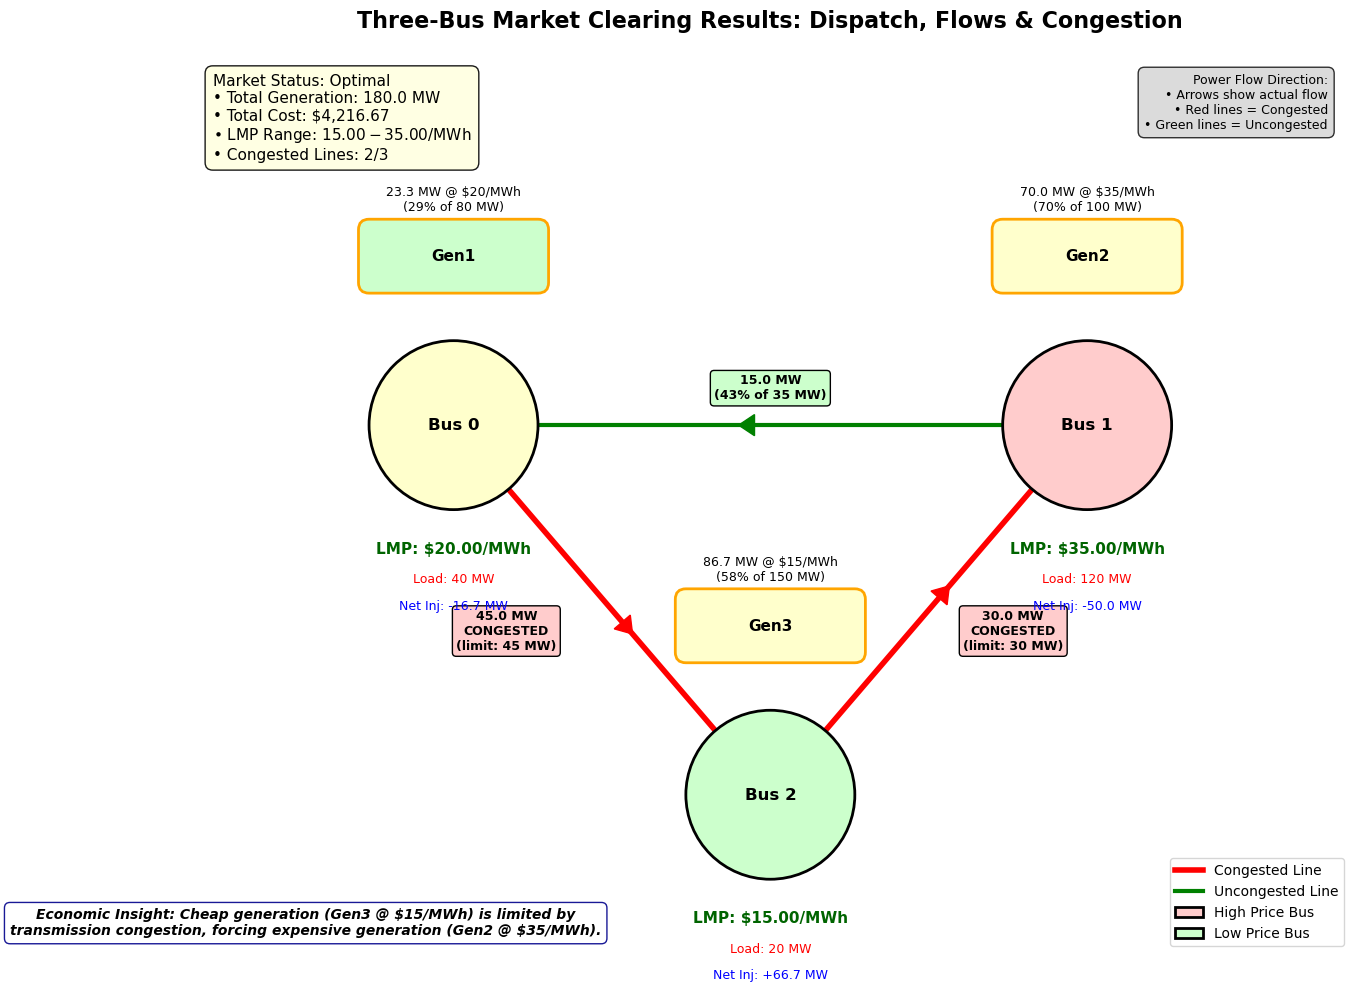

In [8]:
def visualize_three_bus_results(gen_data, demand_data, network_data, results):
    """
    Visualize three-bus market clearing results
    
    Parameters:
    gen_data: dict with generator information
    demand_data: dict with demand at each bus
    network_data: dict with transmission information
    results: dict with optimization results from three_bus_market_clearing()
    """
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Bus positions (triangle layout)
    bus_positions = {
        0: (0.2, 0.5),    # Left
        1: (0.8, 0.5),    # Right
        2: (0.5, 0.15)    # Bottom center
    }
    
    # Function to draw arrow for power flow
    def draw_flow_arrow(ax, start_pos, end_pos, flow, limit, is_congested):
        x1, y1 = start_pos
        x2, y2 = end_pos
        
        # Calculate direction
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        
        # Normalize direction
        dx_norm = dx / length
        dy_norm = dy / length
        
        # Shorten the line to not overlap with bus circles
        bus_radius = 0.08
        x1_adj = x1 + dx_norm * bus_radius
        y1_adj = y1 + dy_norm * bus_radius
        x2_adj = x2 - dx_norm * bus_radius
        y2_adj = y2 - dy_norm * bus_radius
        
        # Line color and width based on congestion
        if is_congested:
            line_color = 'red'
            line_width = 4
        else:
            line_color = 'green'
            line_width = 3
        
        # Draw the line
        ax.plot([x1_adj, x2_adj], [y1_adj, y2_adj], 
                color=line_color, linewidth=line_width, zorder=1)
        
        # Add arrow in the middle if flow is significant
        if abs(flow) > 0.1:
            mid_x = (x1_adj + x2_adj) / 2
            mid_y = (y1_adj + y2_adj) / 2
            
            # Arrow direction based on flow sign
            if flow > 0:
                arrow_dx = dx_norm * 0.03
                arrow_dy = dy_norm * 0.03
            else:
                arrow_dx = -dx_norm * 0.03
                arrow_dy = -dy_norm * 0.03
            
            ax.arrow(mid_x - arrow_dx/2, mid_y - arrow_dy/2, 
                    arrow_dx, arrow_dy,
                    head_width=0.02, head_length=0.015, 
                    fc=line_color, ec=line_color, zorder=2)
    
    # Draw transmission lines with flows
    line_names = ['0-1', '1-2', '0-2']
    line_connections = [(0, 1), (1, 2), (0, 2)]
    
    for i, (from_bus, to_bus) in enumerate(line_connections):
        # Get flow and congestion status
        flow = results['line_flows'][i]
        is_congested = results['congestion'][i]
        limit = network_data['flow_limits'][i]
        
        # Draw flow arrow
        draw_flow_arrow(ax, bus_positions[from_bus], bus_positions[to_bus], 
                       flow, limit, is_congested)
        
        # Add flow label
        x1, y1 = bus_positions[from_bus]
        x2, y2 = bus_positions[to_bus]
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        
        # Offset label to avoid overlapping with line
        if from_bus == 0 and to_bus == 2:  # Line 0-2
            offset_x, offset_y = -0.10, -0.02
        elif from_bus == 1 and to_bus == 2:  # Line 1-2
            offset_x, offset_y = 0.08, -0.02
        else:  # Line 0-1
            offset_x, offset_y = 0, 0.035
        
        # Flow text with congestion indicator
        flow_text = f"{abs(flow):.1f} MW\n"
        if is_congested:
            flow_text += f"CONGESTED\n(limit: {limit} MW)"
            bg_color = '#ffcccc'
        else:
            utilization = abs(flow)/limit*100 if limit > 0 else 0
            flow_text += f"({utilization:.0f}% of {limit} MW)"
            bg_color = '#ccffcc'
        
        ax.text(mid_x + offset_x, mid_y + offset_y, flow_text, 
                ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=bg_color, 
                         edgecolor='black', linewidth=1))
    
    # Calculate net injections
    net_injections = {}
    for bus in range(3):
        gen_at_bus = sum(results['dispatch'][name] for name in gen_data['names'] 
                        if gen_data['bus'][gen_data['names'].index(name)] == bus)
        net_injections[bus] = gen_at_bus - demand_data[bus]
    
    # Draw buses with LMPs
    bus_radius = 0.08
    for bus_id, (x, y) in bus_positions.items():
        # Color based on LMP level
        lmp_value = results['lmps'][bus_id]
        all_lmps = list(results['lmps'].values())
        min_lmp, max_lmp = min(all_lmps), max(all_lmps)
        
        if max_lmp - min_lmp < 0.01:  # All LMPs are the same
            bus_color = '#ffffcc'
        else:
            # Color gradient based on LMP
            if lmp_value >= max_lmp - 0.01:
                bus_color = '#ffcccc'  # Red tint for high price
            elif lmp_value <= min_lmp + 0.01:
                bus_color = '#ccffcc'  # Green tint for low price
            else:
                bus_color = '#ffffcc'  # Yellow tint for medium price
        
        # Draw bus circle
        circle = plt.Circle((x, y), bus_radius, facecolor=bus_color, 
                           edgecolor='black', linewidth=2, zorder=3)
        ax.add_patch(circle)
        
        # Add bus number
        ax.text(x, y, f"Bus {bus_id}", ha='center', va='center', 
                fontsize=12, fontweight='bold')
        
        # Add LMP below bus
        lmp_text = f"LMP: ${lmp_value:.2f}/MWh"
        ax.text(x, y - bus_radius - 0.03, lmp_text, ha='center', va='top', 
                fontsize=11, fontweight='bold', color='darkgreen')
        
        # Add demand and net injection info
        demand_text = f"Load: {demand_data[bus_id]} MW"
        net_inj_text = f"Net Inj: {net_injections[bus_id]:+.1f} MW"
        ax.text(x, y - bus_radius - 0.06, demand_text, ha='center', va='top', 
                fontsize=9, color='red')
        ax.text(x, y - bus_radius - 0.085, net_inj_text, ha='center', va='top', 
                fontsize=9, color='blue')
    
    # Draw generators with dispatch
    gen_offset = 0.08
    for name in gen_data['names']:
        idx = gen_data['names'].index(name)
        bus_id = gen_data['bus'][idx]
        mc = gen_data['mc'][idx]
        dispatch = results['dispatch'][name]
        capacity = gen_data['p_max'][idx]
        
        x, y = bus_positions[bus_id]
        
        # Position generator box above bus
        gen_x = x
        gen_y = y + bus_radius + gen_offset
        
        # Generator box color based on dispatch level
        utilization = dispatch / capacity if capacity > 0 else 0
        if utilization > 0.9:
            gen_color = '#ffcccc'  # Red for high utilization
        elif utilization > 0.5:
            gen_color = '#ffffcc'  # Yellow for medium
        else:
            gen_color = '#ccffcc'  # Green for low
        
        # Generator box
        gen_box = patches.FancyBboxPatch((gen_x - 0.08, gen_y - 0.025), 0.16, 0.05,
                                         boxstyle="round,pad=0.01",
                                         facecolor=gen_color,
                                         edgecolor='orange',
                                         linewidth=2)
        ax.add_patch(gen_box)
        
        # Generator label
        ax.text(gen_x, gen_y, name, ha='center', va='center', 
                fontsize=11, fontweight='bold')
        
        # Generation info
        gen_info = f"{dispatch:.1f} MW @ ${mc}/MWh\n({utilization*100:.0f}% of {capacity} MW)"
        ax.text(gen_x, gen_y + 0.04, gen_info, ha='center', va='bottom', 
                fontsize=9)
    
    # Add title
    ax.set_title('Three-Bus Market Clearing Results: Dispatch, Flows & Congestion', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add results summary box
    total_gen = sum(results['dispatch'].values())
    summary_text = (
        f"Market Status: {results['status']}\n"
        f"• Total Generation: {total_gen:.1f} MW\n"
        f"• Total Cost: ${results['total_cost']:,.2f}\n"
        f"• LMP Range: ${min(results['lmps'].values()):.2f} - ${max(results['lmps'].values()):.2f}/MWh\n"
        f"• Congested Lines: {sum(results['congestion'].values())}/{len(network_data['flow_limits'])}"
    )
    
    ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                      edgecolor='black', alpha=0.9))
    
    # Add power flow direction legend
    flow_legend_text = (
        "Power Flow Direction:\n"
        "• Arrows show actual flow\n"
        "• Red lines = Congested\n"
        "• Green lines = Uncongested"
    )
    
    ax.text(0.98, 0.98, flow_legend_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', 
                      edgecolor='black', alpha=0.8))
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='red', linewidth=4, label='Congested Line'),
        plt.Line2D([0], [0], color='green', linewidth=3, label='Uncongested Line'),
        patches.Circle((0, 0), 0.1, facecolor='#ffcccc', edgecolor='black', 
                       linewidth=2, label='High Price Bus'),
        patches.Circle((0, 0), 0.1, facecolor='#ccffcc', edgecolor='black', 
                       linewidth=2, label='Low Price Bus')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    # Set axis properties
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 0.85)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add economic insight if there's congestion
    if sum(results['congestion'].values()) > 0:
        # Find cheapest and most expensive dispatched generators
        dispatched_gens = [(name, gen_data['mc'][i]) for i, name in enumerate(gen_data['names']) 
                          if results['dispatch'][name] > 0.1]
        if dispatched_gens:
            cheapest = min(dispatched_gens, key=lambda x: x[1])
            expensive = max(dispatched_gens, key=lambda x: x[1])
            
            if cheapest[1] < expensive[1]:
                insight_text = (
                    f"Economic Insight: Cheap generation ({cheapest[0]} @ ${cheapest[1]}/MWh) is limited by\n"
                    f"transmission congestion, forcing expensive generation ({expensive[0]} @ ${expensive[1]}/MWh)."
                )
                ax.text(0.1, 0.02, insight_text, transform=ax.transAxes, 
                        ha='center', fontsize=10, style='italic', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                  edgecolor='darkblue', alpha=0.9))
    
    plt.tight_layout()
    return fig, ax

# Visualize results
fig, ax = visualize_three_bus_results(gen_data, demand_data, network_data, results)

plt.show()

### Exercise 2: Understanding LMP Separation

**Task:** Analyze how transmission constraints create LMP differences.

1. Run the 3-bus market clearing with the given data
2. Identify which transmission lines are congested
3. Compare LMPs at different buses
4. Explain the relationship between congestion and LMP separation
5. Calculate the total congestion rent

In [9]:
# Exercise 2 Solution

# Analyze LMP separation and congestion
print("=== LMP Separation Analysis ===")
print(f"\nLMPs by Bus:")
lmp_values = []
for bus in sorted(results['lmps'].keys()):
    lmp = results['lmps'][bus]
    lmp_values.append(lmp)
    print(f"Bus {bus}: ${lmp:6.2f}/MWh")

# Calculate LMP differences
max_lmp = max(lmp_values)
min_lmp = min(lmp_values)
lmp_spread = max_lmp - min_lmp
print(f"\nLMP Spread: ${lmp_spread:.2f}/MWh (${max_lmp:.2f} - ${min_lmp:.2f})")

# Identify congested lines
print(f"\nCongestion Analysis:")
congested_lines = []
for line, is_congested in results['congestion'].items():
    if is_congested:
        congested_lines.append(line)
        flow = results['line_flows'][line]
        limit = network_data['flow_limits'][line]
        print(f"Line {line_names[line]} is CONGESTED: {flow:.1f} MW (limit: ±{limit} MW)")

if not congested_lines:
    print("No transmission lines are congested.")
    print("Without congestion, all buses should have the same LMP.")
else:
    print(f"\nCongestion creates LMP separation because:")
    print(f"1. Cheap generation cannot reach high-demand areas")
    print(f"2. Expensive local generation must be used")
    print(f"3. LMPs reflect the marginal cost at each location")

# Calculate congestion rent
total_congestion_rent = 0
print(f"\nCongestion Rent Calculation:")
for line in range(len(network_data['flow_limits'])):
    if results['congestion'][line]:
        flow = results['line_flows'][line]
        # Congestion rent = |flow| × (LMP_receiving - LMP_sending)
        # This is simplified - actual calculation requires knowing line direction
        print(f"Line {line_names[line]}: Flow = {flow:.1f} MW")
        
print(f"\nNote: Congestion rent represents the economic value of")
print(f"transmission capacity and can fund transmission investment.")

=== LMP Separation Analysis ===

LMPs by Bus:
Bus 0: $ 20.00/MWh
Bus 1: $ 35.00/MWh
Bus 2: $ 15.00/MWh

LMP Spread: $20.00/MWh ($35.00 - $15.00)

Congestion Analysis:
Line 1-2 is CONGESTED: -30.0 MW (limit: ±30 MW)
Line 0-2 is CONGESTED: 45.0 MW (limit: ±45 MW)

Congestion creates LMP separation because:
1. Cheap generation cannot reach high-demand areas
2. Expensive local generation must be used
3. LMPs reflect the marginal cost at each location

Congestion Rent Calculation:
Line 1-2: Flow = -30.0 MW
Line 0-2: Flow = 45.0 MW

Note: Congestion rent represents the economic value of
transmission capacity and can fund transmission investment.


## Multi-Settlement Markets

### Day-Ahead and Real-Time Markets

Most electricity markets operate with multiple settlement periods:

**Day-Ahead Market:**
- Cleared 24 hours before operating day
- Based on demand and generation forecasts
- Determines unit commitment and energy schedules
- Financial contracts for energy delivery

**Real-Time Market:**
- Cleared every 5-15 minutes during operating day
- Based on actual demand and generation availability
- Adjusts for forecast errors and contingencies
- Final settlement prices for energy

### Two-Settlement System

Participants are settled based on:
1. **Day-ahead schedule** × **Day-ahead LMP**
2. **(Real-time production - Day-ahead schedule)** × **Real-time LMP**

This creates incentives for accurate forecasting and efficient real-time operations.

Let's implement a simplified two-settlement system:

In [10]:
def two_settlement_market(da_demand, rt_demand, generators):
    """
    Simulate a two-settlement market system
    
    Parameters:
    da_demand: float, day-ahead demand forecast (MW)
    rt_demand: float, real-time actual demand (MW)
    generators: dict with generator data
    
    Returns:
    dict with day-ahead and real-time results
    """
    
    # Day-ahead market clearing
    da_results = single_bus_market_clearing(generators, da_demand)
    
    # Real-time market clearing
    rt_results = single_bus_market_clearing(generators, rt_demand)
    
    # Calculate settlement for each generator
    settlements = {}
    total_da_revenue = 0
    total_rt_revenue = 0
    
    for name in generators['names']:
        da_schedule = da_results['dispatch'][name]
        rt_production = rt_results['dispatch'][name]
        
        # Two-settlement calculation
        da_revenue = da_schedule * da_results['lmp']
        rt_revenue = (rt_production - da_schedule) * rt_results['lmp']
        total_revenue = da_revenue + rt_revenue
        
        settlements[name] = {
            'da_schedule': da_schedule,
            'rt_production': rt_production,
            'da_revenue': da_revenue,
            'rt_revenue': rt_revenue,
            'total_revenue': total_revenue
        }
        
        total_da_revenue += da_revenue
        total_rt_revenue += rt_revenue
    
    return {
        'da_results': da_results,
        'rt_results': rt_results,
        'settlements': settlements,
        'demand_error': rt_demand - da_demand,
        'price_volatility': abs(rt_results['lmp'] - da_results['lmp']),
        'total_da_revenue': total_da_revenue,
        'total_rt_revenue': total_rt_revenue
    }

# Example with forecast error
da_demand_forecast = 350  # MW (day-ahead forecast)
rt_demand_actual = 380   # MW (actual real-time demand)

# Run two-settlement market
two_settlement_results = two_settlement_market(da_demand_forecast, rt_demand_actual, generators)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/97c6c21f650f45009a8424b65d209bab-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/97c6c21f650f45009a8424b65d209bab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 13 RHS
At line 15 BOUNDS
At line 21 ENDATA
Problem MODEL has 1 rows, 3 columns and 3 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (0) rows, 3 (0) columns and 3 (0) elements
0  Obj 4750 Primal inf 200 (1)
1  Obj 10250
Optimal - objective value 10250
Optimal objective 10250 - 1 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command

In [11]:
print("=== Two-Settlement Market Results ===")
print(f"\nDemand Forecast Error: {two_settlement_results['demand_error']:+.0f} MW")
print(f"Day-Ahead LMP: ${two_settlement_results['da_results']['lmp']:.2f}/MWh")
print(f"Real-Time LMP:  ${two_settlement_results['rt_results']['lmp']:.2f}/MWh")
print(f"Price Volatility: ${two_settlement_results['price_volatility']:.2f}/MWh")

print(f"\nGenerator Settlements:")
print(f"{'Generator':<8} {'DA Sched':<8} {'RT Prod':<8} {'DA Rev':<8} {'RT Rev':<8} {'Total Rev':<10}")
print("-" * 60)
for name, settlement in two_settlement_results['settlements'].items():
    print(f"{name:<8} {settlement['da_schedule']:>7.1f} {settlement['rt_production']:>7.1f} "
          f"{settlement['da_revenue']:>7.0f} {settlement['rt_revenue']:>+7.0f} "
          f"{settlement['total_revenue']:>9.0f}")

print(f"\nTotal DA Revenue: ${two_settlement_results['total_da_revenue']:,.0f}")
print(f"Total RT Revenue: ${two_settlement_results['total_rt_revenue']:+,.0f}")
print(f"Net Settlement:   ${two_settlement_results['total_da_revenue'] + two_settlement_results['total_rt_revenue']:,.0f}")

=== Two-Settlement Market Results ===

Demand Forecast Error: +30 MW
Day-Ahead LMP: $35.00/MWh
Real-Time LMP:  $35.00/MWh
Price Volatility: $0.00/MWh

Generator Settlements:
Generator DA Sched RT Prod  DA Rev   RT Rev   Total Rev 
------------------------------------------------------------
Coal       200.0   200.0    7000      +0      7000
Gas_CC     150.0   180.0    5250   +1050      6300
Gas_CT       0.0     0.0       0      +0         0

Total DA Revenue: $12,250
Total RT Revenue: $+1,050
Net Settlement:   $13,300


### Exercise 3: Multi-Settlement Analysis

**Task:** Analyze the impact of forecast errors on market settlements.

1. Run the two-settlement market with different demand forecast errors
2. Observe how forecast errors affect real-time prices
3. Calculate which generators benefit from forecast errors
4. Explain the economic incentives created by the two-settlement system

In [12]:
# Exercise 3 Solution

# Test different forecast error scenarios
forecast_scenarios = [
    (300, 320, "Positive Error (+20 MW)"),
    (350, 350, "Perfect Forecast (0 MW)"),
    (400, 370, "Negative Error (-30 MW)")
]

print("=== Multi-Settlement Analysis ===")
print(f"\nImpact of Forecast Errors on Market Outcomes:")
print(f"{'Scenario':<25} {'DA LMP':<8} {'RT LMP':<8} {'RT-DA':<8} {'Winner':<10}")
print("-" * 65)

for da_demand, rt_demand, scenario_name in forecast_scenarios:
    results = two_settlement_market(da_demand, rt_demand, generators)
    
    da_lmp = results['da_results']['lmp']
    rt_lmp = results['rt_results']['lmp']
    price_diff = rt_lmp - da_lmp
    
    # Find generator with highest RT revenue
    max_rt_revenue = max(results['settlements'].values(), key=lambda x: x['rt_revenue'])
    winner = [name for name, settlement in results['settlements'].items() 
              if settlement['rt_revenue'] == max_rt_revenue['rt_revenue']][0]
    
    print(f"{scenario_name:<25} ${da_lmp:>6.2f} ${rt_lmp:>6.2f} ${price_diff:>+6.2f} {winner:<10}")

print(f"\nKey Insights:")
print(f"1. Positive demand errors (underforecasting) → Higher RT prices")
print(f"2. Negative demand errors (overforecasting) → Lower RT prices")
print(f"3. Flexible generators benefit from accurate RT pricing")
print(f"4. Two-settlement system incentivizes accurate forecasting")

# Detailed analysis for one scenario
print(f"\n=== Detailed Analysis: Underforecast Scenario ===")
underforecast = two_settlement_market(300, 330, generators)

print(f"Day-ahead market cleared expecting 300 MW demand")
print(f"Real-time demand was actually 330 MW (+30 MW error)")
print(f"")
print(f"Price Impact:")
print(f"- Day-ahead LMP: ${underforecast['da_results']['lmp']:.2f}/MWh")
print(f"- Real-time LMP: ${underforecast['rt_results']['lmp']:.2f}/MWh")
print(f"- RT premium: ${underforecast['rt_results']['lmp'] - underforecast['da_results']['lmp']:+.2f}/MWh")
print(f"")
print(f"Economic Incentives:")
print(f"- Generators are paid RT LMP for incremental production")
print(f"- High RT prices incentivize flexible resources")
print(f"- Load pays RT LMP for incremental consumption")
print(f"- System encourages accurate forecasting and flexible response")

=== Multi-Settlement Analysis ===

Impact of Forecast Errors on Market Outcomes:
Scenario                  DA LMP   RT LMP   RT-DA    Winner    
-----------------------------------------------------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/2ba1e621d5cc44fe9d4a46c7327cbd80-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/2ba1e621d5cc44fe9d4a46c7327cbd80-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 13 RHS
At line 15 BOUNDS
At line 21 ENDATA
Problem MODEL has 1 rows, 3 columns and 3 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (0) rows, 3 (0) columns and 3 (0) elements
0  Obj 4750 Primal inf 150 (1)
1  Obj 8500
Optimal - objective value 8500
Optimal objective 8500 - 1 iterations time 0.002


## Ancillary Service Markets

### Beyond Energy Markets

Electricity markets include more than just energy:

**Ancillary Services:**
- **Frequency regulation**: Fast response to maintain 60 Hz
- **Spinning reserve**: Online backup power for contingencies
- **Non-spinning reserve**: Offline backup power
- **Voltage support**: Reactive power for voltage control

### Co-Optimization of Energy and Reserves

Modern markets co-optimize energy and ancillary services:
- **Joint clearing**: Single optimization considers all products
- **Opportunity cost pricing**: Reserve prices reflect foregone energy revenue
- **Resource efficiency**: Units provide multiple services simultaneously

Let's implement energy and spinning reserve co-optimization:

In [19]:
def energy_reserve_cooptimization(generators, energy_demand, reserve_requirement):
    """
    Co-optimize energy and spinning reserve markets
    
    Parameters:
    generators: dict with generator data including reserve capability
    energy_demand: float, system energy demand (MW)
    reserve_requirement: float, spinning reserve requirement (MW)
    
    Returns:
    dict with energy dispatch, reserve allocation, and prices
    """
    
    # Create optimization problem
    prob = LpProblem("Energy_Reserve_CoOpt", LpMinimize)
    
    # Decision variables
    p_energy = {}  # Energy production (MW)
    p_reserve = {} # Spinning reserve allocation (MW)
    
    for name in generators['names']:
        idx = generators['names'].index(name)
        p_energy[name] = LpVariable(f"E_{name}", 0, generators['p_max'][idx])
        p_reserve[name] = LpVariable(f"R_{name}", 0, generators['p_max'][idx])
    
    # Objective: minimize total cost (energy + reserve)
    total_cost = 0
    for name in generators['names']:
        idx = generators['names'].index(name)
        energy_cost = generators['mc'][idx] * p_energy[name]
        reserve_cost = generators['reserve_cost'][idx] * p_reserve[name]
        total_cost += energy_cost + reserve_cost
    
    prob += total_cost
    
    # Constraints
    # 1. Energy balance
    prob += lpSum(p_energy[name] for name in generators['names']) == energy_demand, "Energy_Balance"
    
    # 2. Reserve requirement
    prob += lpSum(p_reserve[name] for name in generators['names']) >= reserve_requirement, "Reserve_Requirement"
    
    # 3. Generation capacity limits (energy + reserve ≤ max capacity)
    for name in generators['names']:
        idx = generators['names'].index(name)
        prob += p_energy[name] + p_reserve[name] <= generators['p_max'][idx], f"Capacity_Limit_{name}"
    
    # 4. Minimum generation requirements
    for name in generators['names']:
        idx = generators['names'].index(name)
        prob += p_energy[name] >= generators['p_min'][idx], f"Min_Gen_{name}"
    
    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
        'status': LpStatus[prob.status],
        'energy_dispatch': {name: value(p_energy[name]) for name in generators['names']},
        'reserve_allocation': {name: value(p_reserve[name]) for name in generators['names']},
        'total_cost': value(prob.objective),
        'energy_lmp': prob.constraints['Energy_Balance'].pi,
        'reserve_price': prob.constraints['Reserve_Requirement'].pi
    }
    
    return results

# Enhanced generator data with reserve capability
generators_with_reserves = {
    'names': ['Coal', 'Gas_CC', 'Gas_CT'],
    'mc': [25, 35, 55],                    # Energy marginal cost ($/MWh)
    'reserve_cost': [5, 8, 15],            # Reserve marginal cost ($/MW)
    'p_min': [50, 100, 0],                 # Minimum generation (MW)
    'p_max': [200, 300, 150]               # Maximum generation (MW)
}

energy_demand = 350        # MW
reserve_requirement = 50   # MW spinning reserve

# Run co-optimization
coop_results = energy_reserve_cooptimization(generators_with_reserves, energy_demand, reserve_requirement)

In [20]:
print("=== Energy and Reserve Co-Optimization Results ===")
print(f"Status: {coop_results['status']}")
print(f"\nEnergy LMP: ${coop_results['energy_lmp']:.2f}/MWh")
print(f"Reserve Price: ${coop_results['reserve_price']:.2f}/MW")

print(f"\nGenerator Dispatch:")
print(f"{'Generator':<8} {'Energy':<8} {'Reserve':<8} {'Total':<8} {'Capacity':<8} {'Utilization':<12}")
print("-" * 65)

total_energy = 0
total_reserve = 0

for name in generators_with_reserves['names']:
    idx = generators_with_reserves['names'].index(name)
    energy = coop_results['energy_dispatch'][name]
    reserve = coop_results['reserve_allocation'][name]
    total_commitment = energy + reserve
    capacity = generators_with_reserves['p_max'][idx]
    utilization = total_commitment / capacity * 100
    
    print(f"{name:<8} {energy:>7.1f} {reserve:>7.1f} {total_commitment:>7.1f} "
          f"{capacity:>7.1f} {utilization:>10.1f}%")
    
    total_energy += energy
    total_reserve += reserve

print("-" * 65)
print(f"{'TOTAL':<8} {total_energy:>7.1f} {total_reserve:>7.1f}")
print(f"\nTotal System Cost: ${coop_results['total_cost']:,.2f}")
print(f"Energy Requirement: {energy_demand} MW (Met: {total_energy:.1f} MW)")
print(f"Reserve Requirement: {reserve_requirement} MW (Met: {total_reserve:.1f} MW)")

=== Energy and Reserve Co-Optimization Results ===
Status: Optimal

Energy LMP: $35.00/MWh
Reserve Price: $8.00/MW

Generator Dispatch:
Generator Energy   Reserve  Total    Capacity Utilization 
-----------------------------------------------------------------
Coal       200.0     0.0   200.0   200.0      100.0%
Gas_CC     150.0    50.0   200.0   300.0       66.7%
Gas_CT       0.0     0.0     0.0   150.0        0.0%
-----------------------------------------------------------------
TOTAL      350.0    50.0

Total System Cost: $10,650.00
Energy Requirement: 350 MW (Met: 350.0 MW)
Reserve Requirement: 50 MW (Met: 50.0 MW)


### Exercise 4: Reserve Market Analysis

**Task:** Analyze the economic tradeoffs in reserve allocation.

1. Compare the co-optimized solution to energy-only dispatch
2. Calculate the opportunity cost of providing reserves
3. Determine which generators are most cost-effective for reserves
4. Analyze how reserve requirements affect energy prices

In [14]:
# Exercise 4 Solution

# Compare energy-only vs co-optimized dispatch
print("=== Reserve Market Economic Analysis ===")

# Energy-only dispatch (no reserves)
energy_only = single_bus_market_clearing(generators_with_reserves, energy_demand)

print(f"\nEnergy-Only vs Co-Optimized Comparison:")
print(f"{'Metric':<25} {'Energy-Only':<12} {'Co-Optimized':<12} {'Difference':<12}")
print("-" * 65)
print(f"{'Energy LMP ($/MWh)':<25} {energy_only['lmp']:>10.2f} "
      f"{coop_results['energy_lmp']:>10.2f} "
      f"{coop_results['energy_lmp'] - energy_only['lmp']:>+10.2f}")
print(f"{'Total Cost ($)':<25} {energy_only['total_cost']:>10,.0f} "
      f"{coop_results['total_cost']:>10,.0f} "
      f"{coop_results['total_cost'] - energy_only['total_cost']:>+10,.0f}")

# Calculate opportunity costs
print(f"\nOpportunity Cost Analysis:")
print(f"{'Generator':<10} {'Reserve':<8} {'Energy MC':<10} {'Reserve MC':<11} {'Opp Cost':<10}")
print("-" * 60)

for name in generators_with_reserves['names']:
    idx = generators_with_reserves['names'].index(name)
    reserve_alloc = coop_results['reserve_allocation'][name]
    energy_mc = generators_with_reserves['mc'][idx]
    reserve_mc = generators_with_reserves['reserve_cost'][idx]
    
    # Opportunity cost = forgone energy revenue
    opportunity_cost = max(0, coop_results['energy_lmp'] - energy_mc)
    
    if reserve_alloc > 0.1:  # Only show generators providing reserves
        print(f"{name:<10} {reserve_alloc:>7.1f} ${energy_mc:>8.2f} "
              f"${reserve_mc:>9.2f} ${opportunity_cost:>8.2f}")

# Reserve cost-effectiveness analysis
print(f"\nReserve Cost-Effectiveness Ranking:")
reserve_costs = []
for name in generators_with_reserves['names']:
    idx = generators_with_reserves['names'].index(name)
    energy_mc = generators_with_reserves['mc'][idx]
    reserve_mc = generators_with_reserves['reserve_cost'][idx]
    total_reserve_cost = reserve_mc + max(0, coop_results['energy_lmp'] - energy_mc)
    reserve_costs.append((name, total_reserve_cost, reserve_mc))

# Sort by total reserve cost
reserve_costs.sort(key=lambda x: x[1])

print(f"{'Rank':<5} {'Generator':<10} {'Total Cost':<12} {'Direct Cost':<12}")
print("-" * 45)
for i, (name, total_cost, direct_cost) in enumerate(reserve_costs, 1):
    print(f"{i:<5} {name:<10} ${total_cost:>10.2f} ${direct_cost:>10.2f}")

# Impact of reserve requirements on energy prices
print(f"\nImpact of Reserve Requirements on Energy Markets:")
reserve_scenarios = [0, 25, 50, 75, 100]
price_impacts = []

for reserve_req in reserve_scenarios:
    if reserve_req == 0:
        # Energy-only case
        result = single_bus_market_clearing(generators_with_reserves, energy_demand)
        energy_price = result['lmp']
        reserve_price = 0
    else:
        result = energy_reserve_cooptimization(generators_with_reserves, energy_demand, reserve_req)
        energy_price = result['energy_lmp']
        reserve_price = result['reserve_price']
    
    price_impacts.append((reserve_req, energy_price, reserve_price))

print(f"{'Reserve Req':<12} {'Energy LMP':<12} {'Reserve Price':<13} {'LMP Increase':<12}")
print("-" * 55)
base_lmp = price_impacts[0][1]  # Energy-only LMP
for reserve_req, energy_lmp, reserve_price in price_impacts:
    lmp_increase = energy_lmp - base_lmp
    print(f"{reserve_req:>10} MW ${energy_lmp:>10.2f} ${reserve_price:>11.2f} "
          f"${lmp_increase:>+10.2f}")

print(f"\nKey Insights:")
print(f"1. Reserve requirements increase energy prices due to capacity constraints")
print(f"2. Flexible units (lower opportunity costs) are preferred for reserves")
print(f"3. Co-optimization ensures efficient allocation across energy and reserves")
print(f"4. Reserve prices reflect both direct costs and opportunity costs")

=== Reserve Market Economic Analysis ===
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/9b5ae314c6c8436597c556d7d0aa9687-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/9b5ae314c6c8436597c556d7d0aa9687-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 13 RHS
At line 15 BOUNDS
At line 21 ENDATA
Problem MODEL has 1 rows, 3 columns and 3 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (0) rows, 3 (0) columns and 3 (0) elements
0  Obj 4750 Primal inf 200 (1)
1  Obj 10250
Optimal - objective value 10250
Optimal objective 10250 - 1 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00


Energy-Only vs Co-Optimized Comparison:


## Market Power and Competition

### Market Design Considerations

Electricity markets are vulnerable to market power due to:
- **Demand inelasticity**: Consumers cannot easily reduce consumption when prices rise
- **Supply concentration**: Limited number of generators in some areas
- **Transmission constraints**: Create local market power
- **Must-run requirements**: Reduce competitive pressure

### Market Power Strategies

Generators can exercise market power through:
- **Economic withholding**: Bidding above marginal cost
- **Physical withholding**: Declaring capacity unavailable
- **Strategic maintenance**: Timing outages to create scarcity

### Monitoring and Mitigation

Market monitors use various metrics:
- **Lerner Index**: (Price - Marginal Cost) / Price
- **Pivotal supplier analysis**: Impact of withholding capacity
- **Conduct and impact tests**: Identify anti-competitive behavior

Let's analyze market power in a simplified system:

In [15]:
def analyze_market_power(generators, demand, withhold_capacity=None):
    """
    Analyze market power through capacity withholding
    
    Parameters:
    generators: dict with generator data
    demand: float, system demand (MW)
    withhold_capacity: dict with capacity to withhold by generator
    
    Returns:
    dict with market outcomes and market power metrics
    """
    
    # Create modified generator data if withholding capacity
    if withhold_capacity:
        modified_generators = generators.copy()
        modified_generators['p_max'] = generators['p_max'].copy()
        
        for name, withhold_mw in withhold_capacity.items():
            if name in generators['names']:
                idx = generators['names'].index(name)
                original_capacity = generators['p_max'][idx]
                modified_generators['p_max'][idx] = max(0, original_capacity - withhold_mw)
        
        market_data = modified_generators
    else:
        market_data = generators
    
    # Clear the market
    results = single_bus_market_clearing(market_data, demand)
    
    # Calculate market power metrics
    metrics = {
        'market_results': results,
        'withholding': withhold_capacity or {},
        'lerner_indices': {},
        'total_withholding': 0,
        'price_impact': 0
    }
    
    # Calculate Lerner Index for each generator
    for name in generators['names']:
        idx = generators['names'].index(name)
        marginal_cost = generators['mc'][idx]
        market_price = results['lmp']
        
        if market_price > 0:
            lerner_index = (market_price - marginal_cost) / market_price
            metrics['lerner_indices'][name] = lerner_index
    
    # Calculate total withholding
    if withhold_capacity:
        metrics['total_withholding'] = sum(withhold_capacity.values())
    
    return metrics

# Market power analysis scenarios
demand_test = 380  # MW - tight supply situation

print("=== Market Power Analysis ===")
print(f"System Demand: {demand_test} MW")
print(f"")

# Scenario 1: Competitive market (no withholding)
competitive_result = analyze_market_power(generators, demand_test)
print(f"Scenario 1: Competitive Market")
print(f"Market Price: ${competitive_result['market_results']['lmp']:.2f}/MWh")
print(f"Total Cost: ${competitive_result['market_results']['total_cost']:,.2f}")

print(f"\nGeneration Dispatch:")
for name, dispatch in competitive_result['market_results']['dispatch'].items():
    idx = generators['names'].index(name)
    mc = generators['mc'][idx]
    lerner = competitive_result['lerner_indices'][name]
    print(f"{name}: {dispatch:6.1f} MW, MC=${mc}/MWh, Lerner={lerner:.3f}")

# Scenario 2: Gas_CC withholds 50 MW capacity
withholding = {'Gas_CC': 50}
market_power_result = analyze_market_power(generators, demand_test, withholding)

print(f"\nScenario 2: Gas_CC Withholds 50 MW")
print(f"Market Price: ${market_power_result['market_results']['lmp']:.2f}/MWh")
print(f"Total Cost: ${market_power_result['market_results']['total_cost']:,.2f}")

print(f"\nGeneration Dispatch:")
for name, dispatch in market_power_result['market_results']['dispatch'].items():
    idx = generators['names'].index(name)
    mc = generators['mc'][idx]
    lerner = market_power_result['lerner_indices'][name]
    print(f"{name}: {dispatch:6.1f} MW, MC=${mc}/MWh, Lerner={lerner:.3f}")

# Calculate market power impacts
price_increase = (market_power_result['market_results']['lmp'] - 
                 competitive_result['market_results']['lmp'])
cost_increase = (market_power_result['market_results']['total_cost'] - 
                competitive_result['market_results']['total_cost'])

print(f"\nMarket Power Impact:")
print(f"Price Increase: ${price_increase:+.2f}/MWh ({price_increase/competitive_result['market_results']['lmp']*100:+.1f}%)")
print(f"Cost Increase: ${cost_increase:+,.2f}")
print(f"Consumer Harm: ${demand_test * price_increase:+,.2f} (price × demand)")

# Calculate generator profit impact
print(f"\nGenerator Revenue Impact:")
for name in generators['names']:
    comp_dispatch = competitive_result['market_results']['dispatch'][name]
    comp_price = competitive_result['market_results']['lmp']
    comp_revenue = comp_dispatch * comp_price
    
    mp_dispatch = market_power_result['market_results']['dispatch'][name]
    mp_price = market_power_result['market_results']['lmp']
    mp_revenue = mp_dispatch * mp_price
    
    revenue_change = mp_revenue - comp_revenue
    print(f"{name}: ${revenue_change:+6,.0f} (${comp_revenue:,.0f} → ${mp_revenue:,.0f})")

=== Market Power Analysis ===
System Demand: 380 MW

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/738f3c9a70ed4d28bf80ade0eb341be4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/738f3c9a70ed4d28bf80ade0eb341be4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 13 RHS
At line 15 BOUNDS
At line 21 ENDATA
Problem MODEL has 1 rows, 3 columns and 3 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (0) rows, 3 (0) columns and 3 (0) elements
0  Obj 4750 Primal inf 230 (1)
1  Obj 11300
Optimal - objective value 11300
Optimal objective 11300 - 1 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Scenario 1: Competitive Marke

### Exercise 5: Market Power Detection

**Task:** Develop metrics to identify potential market power abuse.

1. Calculate the pivotal supplier test for each generator
2. Analyze how demand elasticity affects market power
3. Design a simple market power mitigation mechanism
4. Evaluate the tradeoff between market efficiency and market power

In [17]:
# Exercise 5 Solution

def pivotal_supplier_test(generators, demand):
    """
    Test if any generator is pivotal (essential to meet demand)
    """
    results = {}
    total_capacity = sum(generators['p_max'])
    
    for name in generators['names']:
        idx = generators['names'].index(name)
        capacity = generators['p_max'][idx]
        remaining_capacity = total_capacity - capacity
        
        # Generator is pivotal if remaining capacity < demand
        is_pivotal = remaining_capacity < demand
        residual_demand = max(0, demand - remaining_capacity)
        
        results[name] = {
            'capacity': capacity,
            'remaining_capacity': remaining_capacity,
            'is_pivotal': is_pivotal,
            'residual_demand': residual_demand
        }
    
    return results

def market_power_mitigation(generators, demand, price_cap=100):
    """
    Simple price cap mitigation mechanism
    """
    # Run market clearing with price cap constraint
    prob = LpProblem("Price_Cap_Market", LpMinimize)
    
    # Decision variables
    p_gen = {}
    for name in generators['names']:
        idx = generators['names'].index(name)
        p_gen[name] = LpVariable(f"P_{name}", 
                                generators['p_min'][idx], 
                                generators['p_max'][idx])
    
    # Objective: minimize total cost
    prob += lpSum(generators['mc'][generators['names'].index(name)] * p_gen[name] 
                  for name in generators['names'])
    
    # Power balance constraint
    prob += lpSum(p_gen[name] for name in generators['names']) == demand, "Power_Balance"
    
    # Price cap constraint (implicit through merit order)
    # In practice, this would be more complex
    
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    
    uncapped_lmp = prob.constraints['Power_Balance'].pi
    effective_lmp = min(uncapped_lmp, price_cap)
    
    return {
        'dispatch': {name: value(p_gen[name]) for name in generators['names']},
        'uncapped_lmp': uncapped_lmp,
        'effective_lmp': effective_lmp,
        'price_capped': uncapped_lmp > price_cap
    }

print("=== Market Power Detection and Mitigation ===")

# Test with high demand scenario
high_demand = 420  # MW - very tight supply

# Pivotal supplier analysis
print(f"\nPivotal Supplier Analysis (Demand: {high_demand} MW):")
pivotal_results = pivotal_supplier_test(generators, high_demand)

print(f"{'Generator':<10} {'Capacity':<9} {'Remaining':<10} {'Pivotal':<8} {'Residual':<10}")
print("-" * 55)
for name, result in pivotal_results.items():
    print(f"{name:<10} {result['capacity']:>8} {result['remaining_capacity']:>9} "
          f"{str(result['is_pivotal']):<8} {result['residual_demand']:>9}")

pivotal_generators = [name for name, result in pivotal_results.items() if result['is_pivotal']]
if pivotal_generators:
    print(f"\nPivotal generators: {', '.join(pivotal_generators)}")
    print(f"These generators have significant market power!")
else:
    print(f"\nNo pivotal generators - competitive market structure")

# Market power scenarios with different demand levels
print(f"\nMarket Power vs Demand Level:")
demand_scenarios = [300, 350, 400, 450, 500]
print(f"{'Demand':<8} {'LMP':<8} {'Max Lerner':<12} {'Pivotal Gens':<15}")
print("-" * 50)

for test_demand in demand_scenarios:
    if test_demand <= sum(generators['p_max']):  # Feasible demand
        market_result = analyze_market_power(generators, test_demand)
        pivotal_test = pivotal_supplier_test(generators, test_demand)
        
        lmp = market_result['market_results']['lmp']
        max_lerner = max(market_result['lerner_indices'].values())
        pivotal_count = sum(1 for result in pivotal_test.values() if result['is_pivotal'])
        
        print(f"{test_demand:>6} MW ${lmp:>6.2f} {max_lerner:>10.3f} {pivotal_count:>13}")

# Price cap mitigation analysis
print(f"\nPrice Cap Mitigation Analysis:")
test_demand = 420  # High demand scenario
price_caps = [50, 75, 100, 150]

# Uncapped market first
uncapped = analyze_market_power(generators, test_demand)
uncapped_lmp = uncapped['market_results']['lmp']

print(f"\nUncapped Market: LMP = ${uncapped_lmp:.2f}/MWh")
print(f"\nPrice Cap Analysis:")
print(f"{'Price Cap':<12} {'Effective LMP':<13} {'Capped':<8} {'Efficiency Loss':<15}")
print("-" * 55)

for cap in price_caps:
    capped_result = market_power_mitigation(generators, test_demand, cap)
    effective_lmp = capped_result['effective_lmp']
    is_capped = capped_result['price_capped']
    
    # Efficiency loss = higher cost dispatch when price is artificially low
    efficiency_loss = "None" if not is_capped else "Potential"
    
    print(f"${cap:>10} ${effective_lmp:>11.2f} {str(is_capped):<8} {efficiency_loss:<15}")

print(f"\nMarket Design Tradeoffs:")
print(f"\n1. Competition vs Reliability:")
print(f"   - More generators improve competition but increase fixed costs")
print(f"   - Reserve margins reduce market power but increase consumer costs")

print(f"\n2. Price Caps vs Efficiency:")
print(f"   - Price caps limit market power but can cause supply shortages")
print(f"   - Too-low caps discourage investment in new generation")

print(f"\n3. Market Monitoring vs Innovation:")
print(f"   - Strict monitoring prevents abuse but may chill legitimate competition")
print(f"   - Automated mitigation can interfere with price signals")

print(f"\nRecommendations:")
print(f"- Use pivotal supplier tests to identify market power potential")
print(f"- Implement offer caps based on marginal costs plus reasonable markup")
print(f"- Encourage demand response to reduce demand inelasticity")
print(f"- Invest in transmission to reduce local market power")

=== Market Power Detection and Mitigation ===

Pivotal Supplier Analysis (Demand: 420 MW):
Generator  Capacity  Remaining  Pivotal  Residual  
-------------------------------------------------------
Coal            200       450 False            0
Gas_CC          300       350 True            70
Gas_CT          150       500 False            0

Pivotal generators: Gas_CC
These generators have significant market power!

Market Power vs Demand Level:
Demand   LMP      Max Lerner   Pivotal Gens   
--------------------------------------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/ad63239057e8434188d4df200151879f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/ad63239057e8434188d4df200151879f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 13 RHS
At line

## Summary

In this lesson, you learned how electricity markets translate physical system constraints into economic signals through optimization:

### Key Concepts

1. **Market Evolution**: From regulated utilities to competitive markets, with optimization remaining central

2. **Price Formation**: LMPs are determined by the dual variables of power balance constraints in market clearing optimization

3. **Transmission Constraints**: Network limits create LMP separation, reflecting the economic value of transmission capacity

4. **Multi-Settlement**: Day-ahead and real-time markets coordinate to handle uncertainty while maintaining efficiency

5. **Ancillary Services**: Co-optimization of energy and reserves ensures system reliability at minimum cost

6. **Market Power**: Concentration and demand inelasticity create opportunities for strategic behavior that markets must monitor and mitigate

### Practical Skills

- Implementing market clearing algorithms with PuLP
- Analyzing LMP formation and separation
- Modeling multi-period settlement systems
- Co-optimizing energy and ancillary services
- Detecting and analyzing market power
- Understanding the tradeoffs in market design

### Next Steps

In the next lesson, you'll apply these market concepts to more complex power system optimization problems, including unit commitment, optimal power flow, and network-constrained market clearing with AC power flow models.

The optimization techniques you've learned provide the mathematical foundation for understanding how electricity markets work and how they can be designed to achieve efficient, reliable, and competitive outcomes.